# The Helmert transform
$
\begin{bmatrix}
    x\\
    y\\
    z\\
\end{bmatrix}^B
=
\begin{bmatrix}
    t_X\\
    t_Y\\
    t_Z\\
\end{bmatrix}
+
\begin{bmatrix}
    1+s  & -r_Z & r_Y\\
    r_Z  & 1+s  & -r_X\\
    -r_Y & r_X  & 1+s\\
\end{bmatrix}
\cdot
\begin{bmatrix}
    x\\
    y\\
    z\\
\end{bmatrix}^A
$

### Using an external Rust library to speed up lon, lat to [BNG](https://en.wikipedia.org/wiki/Ordnance_Survey_National_Grid) conversion

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.use('TkAgg')
import matplotlib.pyplot as plt
import math
from ctypes import cdll, c_float, c_double, Structure, ARRAY, POINTER, c_int32, c_uint32, c_size_t, c_void_p, cast
from sys import platform
from bng import bng
import pyproj
import ipdb
from array import array
%matplotlib inline

In [2]:
def helmert(x, y, z=0):
    """ Example implementation of Helmert transform """
    tX = -446.448  
    tY = 125.157  
    tZ = -542.060  

    rX = -0.1502  
    rY = -0.2470  
    rZ = -0.8421  

    s = 20.4894 * math.pow(10, -6)
    # For multiple x and y
    # A_vector = np.matrix([[x, y, z], [x, y, z]]).T
    A_vector = np.vstack(np.array([x, y, z]))
    t_matrix = np.vstack(np.array([tX, tY, tZ]))
    conversion = np.matrix([[1 + s, -rZ, rY], [rZ, 1 + s, -rX], [-rY, rX, 1 + s]])
    return t_matrix + (conversion * A_vector)

In [3]:
helmert(-2.018304, 54.589097)

matrix([[-402.49686677],
        [ 181.4468293 ],
        [-550.75780346]])

### Setting up the Rust library. See [here](https://github.com/alexcrichton/rust-ffi-examples/tree/master/python-to-rust) for more

Ensure you've built your Rust library using `cargo build --release`, or the next step will fail.

The boilerplate below can easily be hidden in a wrapper function – it's just here to demonstrate how to call into a shared Rust lib using FFI.

In [4]:
if platform == "darwin":
    ext = "dylib"
else:
    ext = "so"
    
lib = cdll.LoadLibrary('target/release/liblonlat_bng.' + ext)

Define the `ctypes` structures for lon, lat --> BNG conversion

In [5]:
class _FFIArray(Structure):
    """ Convert sequence of floats to a C-compatible void array """
    _fields_ = [("data", c_void_p),
                ("len", c_size_t)]

    @classmethod
    def from_param(cls, seq):
        """  Allow implicit conversions from a sequence of 64-bit floats."""
        return seq if isinstance(seq, cls) else cls(seq)

    def __init__(self, seq, data_type = c_double):
        """
        Convert sequence of values into array, then ctypes Structure

        Rather than checking types (bad), we just try to blam seq
        into a ctypes object using from_buffer. If that doesn't work,
        we try successively more conservative approaches:
        numpy array -> array.array -> read-only buffer -> CPython iterable
        """
        if isinstance(seq, float):
            seq = array('d', [seq])
        try:
            len(seq)
        except TypeError:
             # we've got an iterator or a generator, so consume it
            seq = array('d', seq)
        array_type = data_type * len(seq)
        try:
            raw_seq = array_type.from_buffer(seq.astype(np.float64))
        except (TypeError, AttributeError):
            try:
                raw_seq = array_type.from_buffer_copy(seq.astype(np.float64))
            except (TypeError, AttributeError):
                # it's a list or a tuple
                raw_seq = array_type.from_buffer(array('d', seq))
        self.data = cast(raw_seq, c_void_p)
        self.len = len(seq)
        

class _Result_Tuple(Structure):
    """ Container for returned FFI data """
    _fields_ = [("e", _FFIArray),
                ("n", _FFIArray)]


def _void_array_to_list(restuple, _func, _args):
    """ Convert the FFI result to Python data structures """
    eastings = POINTER(c_double * restuple.e.len).from_buffer_copy(restuple.e)[0]
    northings = POINTER(c_double * restuple.n.len).from_buffer_copy(restuple.n)[0]
    res_list = [list(eastings), list(northings)]
    drop_array(restuple.e, restuple.n)
    return res_list

Define `ctypes` input and return parameters

In [6]:
# Multi-threaded FFI functions
convert_bng = lib.convert_to_bng_threaded
convert_bng.argtypes = (_FFIArray, _FFIArray)
convert_bng.restype = _Result_Tuple
convert_bng.errcheck = _void_array_to_list
convert_bng.__doc__ = """
    Multi-threaded lon, lat --> BNG conversion
    Returns a list of two lists containing Easting and Northing floats,
    respectively
    Uses the Helmert transform
    """

convert_lonlat = lib.convert_to_lonlat_threaded
convert_lonlat.argtypes = (_FFIArray, _FFIArray)
convert_lonlat.restype = _Result_Tuple
convert_lonlat.errcheck = _void_array_to_list
convert_lonlat.__doc__ =  """
    Multi-threaded BNG --> lon, lat conversion
    Returns a list of two lists containing Longitude and Latitude floats,
    respectively
    Uses the Helmert transform
    """

convert_to_osgb36 = lib.convert_to_osgb36_threaded
convert_to_osgb36.argtypes = (_FFIArray, _FFIArray)
convert_to_osgb36.restype = _Result_Tuple
convert_to_osgb36.errcheck = _void_array_to_list
convert_to_osgb36.__doc__ = """
    Multi-threaded lon, lat --> OSGB36 conversion, using OSTN02 data
    Returns a list of two lists containing Easting and Northing floats,
    respectively
    """

convert_osgb36_to_lonlat = lib.convert_osgb36_to_ll_threaded
convert_osgb36_to_lonlat.argtypes = (_FFIArray, _FFIArray)
convert_osgb36_to_lonlat.restype = _Result_Tuple
convert_osgb36_to_lonlat.errcheck = _void_array_to_list
convert_osgb36_to_lonlat.__doc__ = """
    Multi-threaded OSGB36 --> Lon, Lat conversion, using OSTN02 data
    Returns a list of two lists containing Easting and Northing floats,
    respectively
    """

convert_etrs89_to_lonlat = lib.convert_etrs89_to_ll_threaded
convert_etrs89_to_lonlat.argtypes = (_FFIArray, _FFIArray)
convert_etrs89_to_lonlat.restype = _Result_Tuple
convert_etrs89_to_lonlat.errcheck = _void_array_to_list
convert_etrs89_to_lonlat.__doc__ = """
    Multi-threaded ETRS89 Eastings and Northings --> OSGB36 conversion, using OSTN02 data
    Returns a list of two lists containing Easting and Northing floats,
    respectively
    """

convert_etrs89_to_osgb36 = lib.convert_etrs89_to_osgb36_threaded
convert_etrs89_to_osgb36.argtypes = (_FFIArray, _FFIArray)
convert_etrs89_to_osgb36.restype = _Result_Tuple
convert_etrs89_to_osgb36.errcheck = _void_array_to_list
convert_etrs89_to_osgb36.__doc__ = """
    Multi-threaded OSGB36 Eastings and Northings --> ETRS89 Eastings and Northings conversion,
    using OSTN02 data
    Returns a list of two lists containing Easting and Northing floats,
    respectively
    """

convert_osgb36_to_etrs89 = lib.convert_osgb36_to_etrs89_threaded
convert_osgb36_to_etrs89.argtypes = (_FFIArray, _FFIArray)
convert_osgb36_to_etrs89.restype = _Result_Tuple
convert_osgb36_to_etrs89.errcheck = _void_array_to_list
convert_osgb36_to_etrs89.__doc__ = """
    Multi-threaded ETRS89 Eastings and Northings --> Lon, Lat conversion,
    Returns a list of two lists containing Longitude and Latitude floats,
    respectively
    """

convert_epsg3857_to_wgs84 = lib.convert_epsg3857_to_wgs84_threaded
convert_epsg3857_to_wgs84.argtypes = (_FFIArray, _FFIArray)
convert_epsg3857_to_wgs84.restype = _Result_Tuple
convert_epsg3857_to_wgs84.errcheck = _void_array_to_list
convert_epsg3857_to_wgs84.__doc__ = """
    Convert Google Web Mercator (EPSG3857) coordinates to WGS84
    Latitude and Longitude
    Returns a list of two lists containing latitudes and longitudes,
    respectively
    """

# Free FFI-allocated memory
drop_array = lib.drop_float_array
drop_array.argtypes = (_FFIArray, _FFIArray)
drop_array.restype = None

## Simple test of average conversion speed, Python version

## Test: 1MM random points within the UK

In [10]:
# UK bounding box
N = 55.811741
E = 1.768960
S = 49.871159
W = -6.379880

bng = pyproj.Proj(init='epsg:27700')
wgs84 = pyproj.Proj(init='epsg:4326')

num_coords = 1000000
lon_ls = list(np.random.uniform(W, E, [num_coords]))
lat_ls = list(np.random.uniform(S, N, [num_coords]))

### Pure Python

In [ ]:
%%timeit -r50
[bng(lat, lon) for lat, lon in zip(lat_ls, lon_ls)]

### Pyproj

In [8]:
%%timeit -r50
pyproj.transform(wgs84, bng, lon_ls, lat_ls)

1 loop, best of 50: 400 ms per loop


### Multithreaded Rust

In [9]:
%%timeit -r50
convert_bng(lon_ls, lat_ls)

1 loop, best of 50: 665 ms per loop


## Pyproj is now only 1.15x (~15%) faster than Multithreaded Rust, which is 9x faster than pure Python

# Benchmark using cProfile

In [1]:
import cProfile
import pstats
import profile

In [4]:
# calibrate
pr = profile.Profile()
calibration = np.mean([pr.calibrate(100000) for x in xrange(5)])
# add the bias
profile.Profile.bias = calibration

In [12]:
cProfile.run(open('benches/cprofile_rust.py', 'rb'), 'benches/output_stats_rust')
p = pstats.Stats('benches/output_stats_rust')
p.sort_stats('cumulative').print_stats(5)

Wed Feb 24 17:23:40 2016    ffi_benchmarks/output_stats_rust

         1388 function calls in 33.634 seconds

   Ordered by: cumulative time
   List reduced from 30 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1   15.040   15.040   33.634   33.634 ffi_benchmarks/cprofile_rust.py:1(<module>)
       50   13.261    0.265   13.262    0.265 ffi_benchmarks/cprofile_rust.py:59(_void_array_to_list)
      200    0.001    0.000    5.304    0.027 ffi_benchmarks/cprofile_rust.py:19(from_param)
      100    5.300    0.053    5.302    0.053 ffi_benchmarks/cprofile_rust.py:24(__init__)
        2    0.028    0.014    0.028    0.014 {method 'uniform' of 'mtrand.RandomState' objects}




<pstats.Stats instance at 0x11984aef0>

In [9]:
cProfile.run(open('benches/cprofile_pyproj.py', 'rb'), 'benches/output_stats_pyproj')
p = pstats.Stats('benches/output_stats_pyproj')
p.sort_stats('cumulative').print_stats(10)

Wed Feb 24 16:09:30 2016    ffi_benchmarks/output_stats_pyproj

         822 function calls in 20.225 seconds

   Ordered by: cumulative time
   List reduced from 20 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.725    0.725   20.225   20.225 ffi_benchmarks/cprofile_pyproj.py:1(<module>)
       50    0.001    0.000   19.473    0.389 /Users/sth/dev/lonlat_bng/venv/lib/python2.7/site-packages/pyproj/__init__.py:418(transform)
       50   13.097    0.262   13.097    0.262 {_proj._transform}
      100    5.339    0.053    5.339    0.053 /Users/sth/dev/lonlat_bng/venv/lib/python2.7/site-packages/pyproj/__init__.py:521(_copytobuffer)
      100    0.000    0.000    1.035    0.010 /Users/sth/dev/lonlat_bng/venv/lib/python2.7/site-packages/pyproj/__init__.py:577(_convertback)
      100    1.035    0.010    1.035    0.010 {method 'tolist' of 'array.array' objects}
        2    0.027    0.014    0.027    0.014 {method 'unifor

<pstats.Stats instance at 0x11785f440>

In [4]:
# make graph text look good - only run this if you know what you're doing
from matplotlib import rc
rc('font', **{'family':'sans-serif',
    'sans-serif':['Helvetica'],
    'monospace': ['Inconsolata'],
    'serif': ['Helvetica']})
rc('text', **{'usetex': True})
rc('text', **{'latex.preamble': '\usepackage{sfmath}'})

In [49]:
df = pd.read_csv("benches/benchmarks.csv",
    dtype={
        'crossbeam': np.float64,
        'crossbeam_error': np.float64,
        'threads': np.float64,
        'rayon': np.float64,
        'rayon_error': np.float64,
        'weight': np.float64,
        'num_points': np.float64,
        'cores': np.float64,
    }    
)

df.head(20)

,time,error,ivariable,num_points,cores,method
0,36382498,22667649,1,100000,2,crossbeam
1,16095737,10256972,2,100000,2,crossbeam
2,16219817,10079940,4,100000,2,crossbeam
3,16454841,10236871,8,100000,2,crossbeam
4,16755991,10263327,16,100000,2,crossbeam
5,17856895,10031590,32,100000,2,crossbeam
6,16207584,10847012,1,100000,2,rayon
7,16657233,9949211,2,100000,2,rayon
8,16386362,11144556,4,100000,2,rayon
9,16000969,10038207,100,100000,2,rayon


# Comparing and Optimising Crossbeam and Rayon

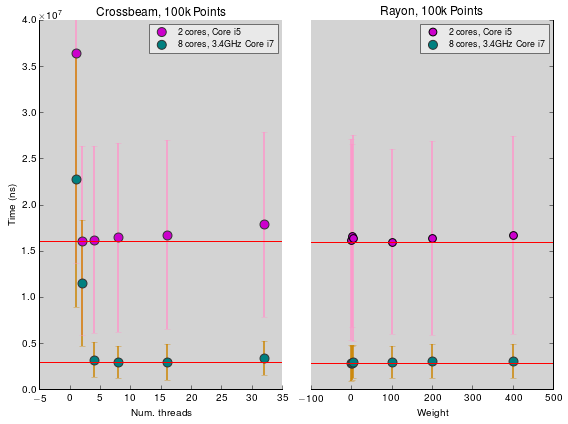

In [52]:
plt.clf()
fig = plt.figure(figsize=(8, 6))

# Crossbeam
# filter by cores and method
df_cb = df[(df.cores == 2) & (df.method == "crossbeam")]
ax1 = fig.add_subplot(121, axisbg='#d3d3d3')
threads = plt.scatter(df_cb['ivariable'], df_cb['time'],
    color='#CC00CC',
    edgecolor='#333333',
    marker='o',
    lw=1,
    s=80,
    alpha=1.0,
    zorder=2,
)
ax1.set_ylim(0, 40000000)
plt.errorbar(df_cb['ivariable'], df_cb['time'], yerr=df_cb['error'],
    color='#ff96ca',
    linestyle="None",
    lw=2.,
    alpha=0.75,
    zorder=1     
)
# filter by cores and method (8 cores)
df_cb_ = df[(df.cores == 8) & (df.method == "crossbeam")]
threads_ = plt.scatter(df_cb_['ivariable'], df_cb_['time'],
    color='#008080',
    edgecolor='#333333',
    marker='o',
    lw=1,
    s=80,
    alpha=1.0,
    zorder=2,
)
plt.errorbar(df_cb_['ivariable'].values, df_cb_['time'].values, yerr=df_cb_['error'].values,
    linestyle="None",
    color='#cc8400',
    lw=2.,
    alpha=0.75,
    zorder=1     
)

# Legend
leg = plt.legend(
    (threads, threads_),
    ('2 cores, Core i5', '8 cores, 3.4GHz Core i7'),
    loc='upper right',
    scatterpoints=1,
    fontsize=9)
leg.get_frame().set_alpha(0.5)

plt.ylabel("Time (ns)")
plt.xlabel("Num. threads")
# highlight fastest runs
plt.axhline(df_cb.time.min(), color='red')
plt.axhline(df_cb_.time.min(), color='red')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# x ticks
plt.tick_params(
    axis='x',
    which='both',
    top='off',
    bottom='on',
    labelbottom='on')

# y ticks
plt.tick_params(
    axis='y',
    which='both',
    left='on',
    right='off',
    labelbottom='off')


plt.title("Crossbeam, 100k Points", fontsize=12)
plt.tight_layout()

# Rayon
# filter by cores and method
df_ry = df[(df.cores == 2) & (df.method == "rayon")]
ax2 = fig.add_subplot(122, axisbg='#d3d3d3')
rayon = plt.scatter(df_ry['ivariable'], df_ry['time'],
    color='#CC00CC',
    edgecolor='#000000',
    marker='o',
    lw=1,
    s=60,
    alpha=1.0,
    zorder=2,
)
ax2.set_ylim(0, 40000000)
# pandas bug, so use .values
plt.errorbar(df_ry['ivariable'].values, df_ry['time'].values, yerr=df_ry['error'].values,
    linestyle="None",
    color='#ff96ca',
    lw=2.,
    alpha=0.75,
    zorder=1 
)

# filter by cores and method (8 cores)
df_ry_ = df[(df.cores == 8) & (df.method == "rayon")]
rayon_ = plt.scatter(df_ry_['ivariable'], df_ry_['time'],
    color='#008080',
    edgecolor='#333333',
    marker='o',
    lw=1,
    s=80,
    alpha=1.0,
    zorder=2,
)
plt.errorbar(df_ry_['ivariable'].values, df_ry_['time'].values, yerr=df_ry_['error'].values,
    linestyle="None",
    color='#cc8400',
    lw=2.,
    alpha=0.75,
    zorder=1     
)

plt.xlabel("Weight")
ax2.set_yticklabels([])
# highlight fastest runs
plt.axhline(df_ry.time.min(), color='red')
plt.axhline(df_ry_.time.min(), color='red')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(True)
ax2.spines['left'].set_visible(False)
plt.title("Rayon, 100k Points", fontsize=12)

leg = plt.legend(
    (rayon, rayon_),
    ('2 cores, Core i5', '8 cores, 3.4GHz Core i7'),
    loc='upper right',
    scatterpoints=1,
    fontsize=9)
leg.get_frame().set_alpha(0.5)

# x ticks
# x ticks
plt.tick_params(
    axis='x',
    which='both',
    top='off',
    bottom='on',
    labelbottom='on')

#  y ticks
plt.tick_params(
    axis='y',
    which='both',
    left='off',
    right='on',
    labelbottom='off')

# output
plt.tight_layout()
plt.savefig(
    'crossbeam_v_rayon.png',
    format="png", bbox_inches='tight',
    alpha=True, dpi=100)
plt.show()